# Training the Model

This notebook builds a classification model to predict the outcome of football matches using engineered features from historical team performance data. The model is trained using CatBoost, a gradient boosting algorithm that handles missing values and categorical features natively. The goal is to classify match results as home win, away win, or draw based on team strength, form, and other match statistics.

### Imports

In [65]:
import pandas as pd
import numpy as np
from catboost import CatBoostClassifier, Pool
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns

match_data = pd.read_csv("../data/training_data.csv")

match_data=match_data.drop(columns=['DATE'],axis=1)

print(match_data.dtypes)
print(match_data.columns.tolist())
match_data.head()

HOME_TEAM                      object
HOME_STRENGTH                 float64
HOME_LEAGUE_STRENGTH          float64
HOME_GOALS_FOR_LAST3          float64
HOME_GOALS_AGAINST_LAST3      float64
HOME_STRENGTH_LAST3           float64
HOME_LEAGUE_STRENGTH_LAST3    float64
HOME_TARGET_LAST3             float64
HOME_FOULS_LAST3              float64
HOME_CORNERS_LAST3            float64
HOME_YELLOW_LAST3             float64
HOME_RED_LAST3                float64
HOME_FORM_LAST3               float64
AWAY_TEAM                      object
AWAY_STRENGTH                 float64
AWAY_LEAGUE_STRENGTH          float64
AWAY_GOALS_FOR_LAST3          float64
AWAY_GOALS_AGAINST_LAST3      float64
AWAY_STRENGTH_LAST3           float64
AWAY_LEAGUE_STRENGTH_LAST3    float64
AWAY_TARGET_LAST3             float64
AWAY_FOULS_LAST3              float64
AWAY_CORNERS_LAST3            float64
AWAY_YELLOW_LAST3             float64
AWAY_RED_LAST3                float64
AWAY_FORM_LAST3               float64
RESULT      

,HOME_TEAM,HOME_STRENGTH,HOME_LEAGUE_STRENGTH,HOME_GOALS_FOR_LAST3,HOME_GOALS_AGAINST_LAST3,HOME_STRENGTH_LAST3,HOME_LEAGUE_STRENGTH_LAST3,HOME_TARGET_LAST3,HOME_FOULS_LAST3,HOME_CORNERS_LAST3,...,AWAY_CORNERS_LAST3,AWAY_YELLOW_LAST3,AWAY_RED_LAST3,AWAY_FORM_LAST3,RESULT,STRENGTH_DIFF,LEAGUE_STRENGTH_DIFF,FORM_DIFF,HOME_GOAL_DIFF_LAST3,AWAY_GOAL_DIFF_LAST3
0,AFC Ajax,84.3,76.2,3.000000,0.666667,84.3,76.2,NaN,NaN,NaN,...,NaN,NaN,NaN,3.0,H,-4.5,-2.4,0.0,2.333333,2.000000
1,AFC Ajax,84.3,76.2,2.666667,1.666667,84.3,76.2,NaN,NaN,NaN,...,7.333333,2.000000,0.333333,3.0,A,-4.7,-2.4,0.0,1.000000,1.333333
2,AVS,75.7,78.6,1.333333,2.000000,75.7,78.6,3.000000,12.000000,2.666667,...,6.000000,1.000000,0.333333,6.0,H,-2.6,0.0,0.0,-0.666667,0.000000
3,AVS,75.7,78.6,0.666667,1.666667,75.7,78.6,1.666667,11.333333,2.333333,...,4.666667,2.333333,0.000000,7.0,D,-0.4,0.0,0.0,-1.000000,-1.333333
4,AVS,75.7,78.6,0.333333,2.000000,75.7,78.6,1.333333,11.333333,5.000000,...,6.333333,1.666667,0.000000,7.0,A,-4.7,0.0,0.0,-1.666667,-1.000000


### Set Target and Categorical Features

In [66]:
# Define target and features
target_col = "RESULT"
categorical_cols = ["HOME_TEAM", "AWAY_TEAM"]

X = match_data.drop(columns=[target_col])
y = match_data[target_col]

### Training Testing Split

In [67]:
# Split dataset into train and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.1, stratify=y, random_state=42
)

# Create CatBoost Pool objects for better performance
train_pool = Pool(X_train, y_train, cat_features=categorical_cols)
test_pool = Pool(X_test, y_test, cat_features=categorical_cols)

### Train Model

In [68]:
model = CatBoostClassifier(
    iterations=500,
    learning_rate=0.05,
    depth=6,
    loss_function='MultiClass',
    eval_metric='Accuracy',
    verbose=100,
    random_seed=42
)

model.fit(train_pool, eval_set=test_pool)


0:	learn: 0.5030517	test: 0.5090455	best: 0.5090455 (0)	total: 42.7ms	remaining: 21.3s
100:	learn: 0.5232348	test: 0.5215221	best: 0.5221460 (81)	total: 4.88s	remaining: 19.3s
200:	learn: 0.5359273	test: 0.5258890	best: 0.5277604 (189)	total: 10.3s	remaining: 15.3s
300:	learn: 0.5505618	test: 0.5252651	best: 0.5277604 (189)	total: 15.8s	remaining: 10.4s
400:	learn: 0.5635317	test: 0.5233936	best: 0.5277604 (189)	total: 21s	remaining: 5.19s
499:	learn: 0.5764322	test: 0.5221460	best: 0.5277604 (189)	total: 26.3s	remaining: 0us

bestTest = 0.5277604492
bestIteration = 189

Shrink model to first 190 iterations.


### Feature Selection

As we can see, that the Accuracy is around 50% which is the same as random guess. So now we should try to possibly reduce the number of features that may be resulting in the model getting confused.

,Feature Id,Importances
0,STRENGTH_DIFF,24.833728
1,HOME_TEAM,15.151892
2,AWAY_TEAM,14.770099
3,AWAY_STRENGTH,2.942562
4,HOME_STRENGTH,2.723293
5,HOME_GOAL_DIFF_LAST3,2.704099
6,AWAY_GOALS_FOR_LAST3,2.702864
7,AWAY_STRENGTH_LAST3,2.591013
8,AWAY_GOAL_DIFF_LAST3,2.158713
9,HOME_LEAGUE_STRENGTH_LAST3,2.116878


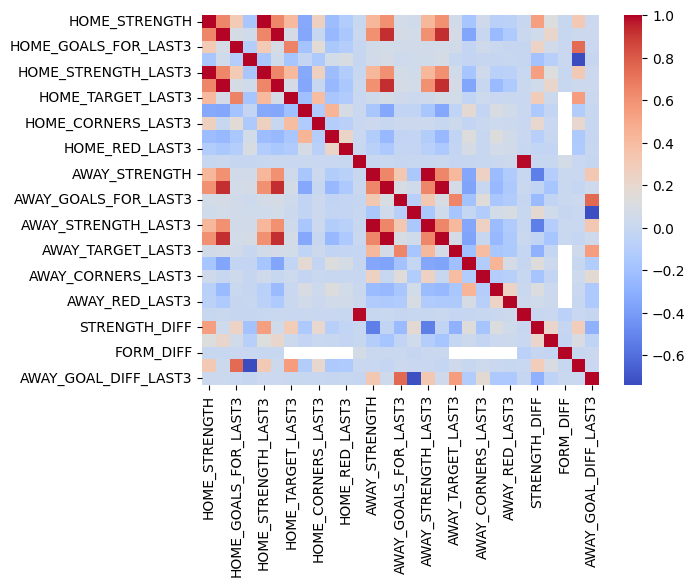

In [69]:
model.get_feature_importance(prettified=True)

numeric_data = match_data.select_dtypes(include=["number"])
sns.heatmap(numeric_data.corr(), annot=False, cmap='coolwarm')

model.get_feature_importance(prettified=True)

### Train a New Model, With Subset of Features

I am also going to change the target, as two-level classification is easier than three-level. So the outcomes will now be Home Win or No Home Win

In [70]:
drop_cols = [
    "HOME_YELLOW_LAST3",
    "HOME_CORNERS_LAST3",
    "AWAY_CORNERS_LAST3",
    "AWAY_YELLOW_LAST3",
    "HOME_FOULS_LAST3",
    "AWAY_FOULS_LAST3",
    "AWAY_RED_LAST3",
    "HOME_RED_LAST3",
    "FORM_DIFF",

]

# Create binary label: 1 if home team wins, 0 otherwise
match_data['HOME_WIN'] = match_data['RESULT'].apply(lambda x: 1 if x == 'H' else 0)

# Create a new dataframe without those columns + columns to exclude like teams, date, home win
X = match_data.drop(columns=drop_cols + ["HOME_TEAM", "AWAY_TEAM", "HOME_WIN","RESULT"])

# Target column
y = match_data["HOME_WIN"]

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

train_pool = Pool(X_train, y_train)
test_pool = Pool(X_test, y_test)

# Initialize and train model
model = CatBoostClassifier(iterations=500, eval_metric='Accuracy', random_seed=42, verbose=100)
model.fit(train_pool, eval_set=test_pool, use_best_model=True)

# Evaluate
y_pred = model.predict(X_test)
print("Test Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

Learning rate set to 0.082815
0:	learn: 0.6232487	test: 0.6331878	best: 0.6331878 (0)	total: 9.72ms	remaining: 4.85s
100:	learn: 0.6634069	test: 0.6444167	best: 0.6481597 (96)	total: 1.42s	remaining: 5.6s
200:	learn: 0.6865030	test: 0.6531503	best: 0.6531503 (200)	total: 2.72s	remaining: 4.04s
300:	learn: 0.7067554	test: 0.6537742	best: 0.6550218 (263)	total: 3.86s	remaining: 2.56s
400:	learn: 0.7227077	test: 0.6600125	best: 0.6600125 (391)	total: 4.92s	remaining: 1.21s
499:	learn: 0.7427521	test: 0.6587648	best: 0.6631316 (481)	total: 6.06s	remaining: 0us

bestTest = 0.6631316282
bestIteration = 481

Shrink model to first 482 iterations.
Test Accuracy: 0.6631316281971303
              precision    recall  f1-score   support

           0       0.67      0.77      0.72       885
           1       0.65      0.53      0.58       718

    accuracy                           0.66      1603
   macro avg       0.66      0.65      0.65      1603
weighted avg       0.66      0.66      0.66    

### Tune the Parameters of the Model

Now that we have achieved a higher accuracy by trying out different parameters to which achieves the highest accuracy

In [71]:
param_dist = {
    'iterations': [300, 500, 700],
    'depth': [4, 6, 8, 10],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'l2_leaf_reg': [1, 3, 5, 7, 9],
    'bagging_temperature': [0, 0.5, 1],
    'random_strength': [1, 5, 10],
    'border_count': [32, 64, 128]
}

model = CatBoostClassifier(
    eval_metric='Accuracy',
    random_seed=42,
    verbose=0
)

random_search = RandomizedSearchCV(
    estimator=model,
    param_distributions=param_dist,
    n_iter=20,  # Number of parameter combinations to try
    scoring='accuracy',
    cv=3,
    verbose=2,
    n_jobs=-1
)

random_search.fit(X_train, y_train)

print("Best Parameters:")
print(random_search.best_params_)

print("\nBest Cross-Validation Accuracy:")
print(random_search.best_score_)

# Use the best model to predict on test set
best_model = random_search.best_estimator_
y_pred = best_model.predict(X_test)

print("\nTest Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

Fitting 3 folds for each of 20 candidates, totalling 60 fits
Best Parameters:
{'random_strength': 1, 'learning_rate': 0.01, 'l2_leaf_reg': 5, 'iterations': 700, 'depth': 10, 'border_count': 64, 'bagging_temperature': 1}

Best Cross-Validation Accuracy:
0.637397697322791

Test Accuracy: 0.6581409856519027
              precision    recall  f1-score   support

           0       0.66      0.78      0.72       885
           1       0.65      0.51      0.57       718

    accuracy                           0.66      1603
   macro avg       0.66      0.64      0.64      1603
weighted avg       0.66      0.66      0.65      1603

